# Inference Example with Medusa

In this Jupyter notebook, we're going to demonstrate how to perform inference using the Medusa model on an interesting story prompt. Let's get the ball rolling!

In [12]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"# os.environ["CUDA_VISIBLE_DEVICES"] = "3" # define GPU id, remove if you want to use all GPUs available
import torch
from tqdm import tqdm
import time
from contextlib import contextmanager
import numpy as np
import pandas as pd
from medusa.model.modeling_llama_kv import LlamaForCausalLM as KVLlamaForCausalLM
from medusa.model.medusa_model import MedusaModel
from medusa.model.kv_cache import *
from medusa.model.utils import *
from medusa.model.medusa_choices import *
import transformers
from huggingface_hub import hf_hub_download
import torch.nn.functional as F

/workspace/laurel/opt/miniconda3-laurel/envs/medusa_ori/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/workspace/laurel/opt/miniconda3-laurel/envs/medusa_ori/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/workspace/laurel/opt/miniconda3-laurel/envs/medusa_ori/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


## Medusa Forward Function

We define the medusa_forward function that will be used for generating stories based on the provided prompts.


In [13]:
activations = {}

def capture_activation(layer_name):
    def hook(module, input, output):
        activations[layer_name] = output.detach().cpu()
    return hook

In [14]:
@contextmanager
def timed(wall_times, key):
    start = time.time()
    torch.cuda.synchronize()
    yield
    torch.cuda.synchronize()
    end = time.time()
    elapsed_time = end - start
    wall_times[key].append(elapsed_time)

def register_hooks(model):
    for idx, layer in enumerate(model.base_model.model.layers):
        mlp_module = layer.mlp
        layer_name = f"layer_{idx+1}_mlp"
        mlp_module.register_forward_hook(capture_activation(layer_name))

def medusa_forward(input_ids, model, tokenizer, medusa_choices, temperature, posterior_threshold, posterior_alpha, max_steps = 512):
    wall_times = {'medusa': [], 'tree': [], 'posterior': [], 'update': [], 'init': []}
    
    with timed(wall_times, 'init'):
        if hasattr(model, "medusa_choices") and model.medusa_choices == medusa_choices:
            # Load the cached medusa buffer
            medusa_buffers = model.medusa_buffers
        else:
            # Initialize the medusa buffer
            medusa_buffers = generate_medusa_buffers(
                medusa_choices, device=model.base_model.device
            )
        model.medusa_buffers = medusa_buffers
        model.medusa_choices = medusa_choices

        # Initialize the past key and value states
        if hasattr(model, "past_key_values"):
            past_key_values = model.past_key_values
            past_key_values_data = model.past_key_values_data
            current_length_data = model.current_length_data
            # Reset the past key and value states
            current_length_data.zero_()
        else:
            (
                past_key_values,
                past_key_values_data,
                current_length_data,
            ) = initialize_past_key_values(model.base_model)
            model.past_key_values = past_key_values
            model.past_key_values_data = past_key_values_data
            model.current_length_data = current_length_data

        input_len = input_ids.shape[1]
        reset_medusa_mode(model)
        medusa_logits, logits = initialize_medusa(
                input_ids, model, medusa_buffers["medusa_attn_mask"], past_key_values
        )
    new_token = 0

    for idx in range(max_steps): 
        with timed(wall_times, 'medusa'):
            candidates, tree_candidates = generate_candidates(
                    medusa_logits,
                    logits,
                    medusa_buffers["tree_indices"],
                    medusa_buffers["retrieve_indices"],
                )

        with timed(wall_times, 'tree'):
            medusa_logits, logits, outputs = tree_decoding(
                    model,
                    tree_candidates,
                    past_key_values,
                    medusa_buffers["medusa_position_ids"],
                    input_ids,
                    medusa_buffers["retrieve_indices"],
                )

        with timed(wall_times, 'posterior'):
            best_candidate, accept_length = evaluate_posterior(
                    logits, candidates, temperature, posterior_threshold, posterior_alpha
                )
        
        with timed(wall_times, 'update'):
            input_ids, logits, medusa_logits, new_token = update_inference_inputs(
                    input_ids,
                    candidates,
                    best_candidate,
                    accept_length,
                    medusa_buffers["retrieve_indices"],
                    outputs,
                    logits,
                    medusa_logits,
                    new_token,
                    past_key_values_data,
                    current_length_data,
                )

        if tokenizer.eos_token_id in input_ids[0, input_len:].tolist():
            break

    return input_ids, new_token, idx, wall_times


## Model Loading

We load the model and tokenizer using the specified paths and configurations.


In [15]:
model_name = '/workspace/laurel/models/medusa-vicuna-7b-v1.3'
model = MedusaModel.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    device_map="auto"
)
tokenizer = model.get_tokenizer()

medusa_choices = mc_sim_7b_63

You are using a model of type llama to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]/workspace/laurel/opt/miniconda3-laurel/envs/medusa_ori/lib/python3.11/site-packages/transformers/modeling_utils.py:484: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details

In [16]:
register_hooks(model)

## Setting Inference Parameters

Next, we set some parameters that will be used during the inference process.


In [17]:
temperature = 0.
posterior_threshold = 0.09
posterior_alpha = 0.3

## Setting The Prompt

The following is the story prompt we will use for generating our story in the demo.


In [18]:
path="/workspace/laurel/project/Medusa/layerwise/data/gsm8k/main/test-00000-of-00001.parquet"
df = pd.read_parquet(path)
test = df["question"].str.replace("\n", " ")

In [7]:
# prompt = "A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Hi, could you share a tale about a charming llama that grows Medusa-like hair and starts its own coffee shop? ASSISTANT:"

## Performing Inference

Using the set parameters and the defined function, let's generate our story!


In [32]:
cross_entropy_losses = []
kl_div_losses = []

for prompt in test:    
    with torch.inference_mode():
        input_ids = tokenizer([prompt]).input_ids
        output_ids, new_token, idx, wall_time = medusa_forward(
                        torch.as_tensor(input_ids).cuda(),
                        model,
                        tokenizer,
                        medusa_choices,
                        temperature,
                        posterior_threshold,
                        posterior_alpha,
                    )
        output_ids = output_ids[0][len(input_ids[0]) :]
        # print("Output length:", output_ids.size(-1))
        # print("Compression ratio:", new_token / idx)

        output_text = tokenizer.decode(output_ids, skip_special_tokens=True)

        cross_entropy_loss = []
        kl_div_loss = []

        for i in range(1, 32):
            layer1_name = f'layer_{i}_mlp'
            layer2_name = f'layer_{i+1}_mlp'

            # Extract logits from consecutive layers
            layer1_logits = activations[layer1_name][0]
            layer2_logits = activations[layer2_name][0]

            # Cross-Entropy
            layer2_targets = layer2_logits.argmax(dim=-1)
            ce_loss = F.cross_entropy(layer1_logits, layer2_targets, reduction='mean')
            
            # KL Divergence
            layer1_probs = F.softmax(layer1_logits, dim=-1)
            layer2_probs = F.softmax(layer2_logits, dim=-1)
            kl_loss = F.kl_div(layer1_probs.log(), layer2_probs, reduction='batchmean')
            # if torch.isnan(kl_div_loss) or torch.isinf(kl_div_loss):
            #     print(f"Layer {i} logits: Min: {layer1_logits.min()}, Max: {layer1_logits.max()}, Mean: {layer1_logits.mean()}")
            #     print(f"Layer {i+1} logits: Min: {layer2_logits.min()}, Max: {layer2_logits.max()}, Mean: {layer2_logits.mean()}")

            cross_entropy_loss.append(ce_loss.item())
            kl_div_loss.append(kl_loss.item())
        
        cross_entropy_losses.append(cross_entropy_loss)
        kl_div_losses.append(kl_div_loss)

In [33]:
cross_entropy_losses = np.array(cross_entropy_losses)
mean_cross_entropy = np.mean(cross_entropy_losses, axis=0)
kl_div_losses = np.array(kl_div_losses)
mean_kl_div = np.mean(kl_div_losses, axis=0)

## Decoding The Output

Let's decode the generated output to obtain our story.


In [9]:
# output = tokenizer.decode(
#                     output_ids,
#                     spaces_between_special_tokens=False,
#                 )
# print(output)

Once upon a time, in a small village nestled in the Andes mountains, there lived a charming llama named Luna. Luna was known for her kind heart and her love of coffee. She would often spend her afternoons sipping on a steaming cup of joe at the local café, chatting with the villagers and enjoying the warmth of the sun on her back.

One day, as Luna was grazing on some fresh grass, she noticed that her hair was starting to grow longer and thicker. At first, she didn't think much of it, but as the days went on, her hair continued to grow and change. It became thick and wiry, with sharp spikes protruding from it.

Luna was confused and a little scared by her new appearance. She had always been a gentle creature, and now she looked like a monster. She knew that she couldn't stay in the village anymore, so she set off on a journey to find a new home.

As she wandered through the mountains, Luna stumbled upon a beautiful clearing. In the center of the clearing stood a small cottage, with a s

In [34]:
cross_entropy_losses = []
kl_div_losses = []

for i in range(1, 32):
    layer1_name = f'layer_{i}_mlp'
    layer2_name = f'layer_{i+1}_mlp'

    # Extract logits from consecutive layers
    layer1_logits = activations[layer1_name][0]
    layer2_logits = activations[layer2_name][0]

    # Cross-Entropy
    layer2_targets = layer2_logits.argmax(dim=-1)
    cross_entropy_loss = F.cross_entropy(layer1_logits, layer2_targets, reduction='mean')
    
    # KL Divergence
    layer1_probs = F.softmax(layer1_logits, dim=-1)
    layer2_probs = F.softmax(layer2_logits, dim=-1)
    kl_div_loss = F.kl_div(layer1_probs.log(), layer2_probs, reduction='batchmean')
    # if torch.isnan(kl_div_loss) or torch.isinf(kl_div_loss):
    #     print(f"Layer {i} logits: Min: {layer1_logits.min()}, Max: {layer1_logits.max()}, Mean: {layer1_logits.mean()}")
    #     print(f"Layer {i+1} logits: Min: {layer2_logits.min()}, Max: {layer2_logits.max()}, Mean: {layer2_logits.mean()}")

    cross_entropy_losses.append(cross_entropy_loss.item())
    kl_div_losses.append(kl_div_loss.item())

    # print(f"Layer {i} -> Layer {i+1}: Cross-Entropy Loss = {cross_entropy_loss.item()}, KL Divergence Loss = {kl_div_loss.item()}")

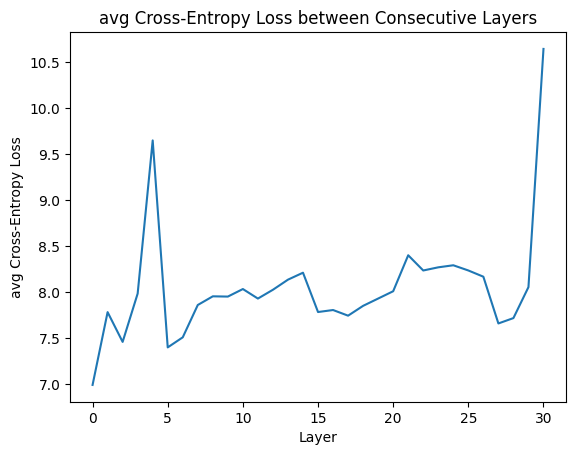

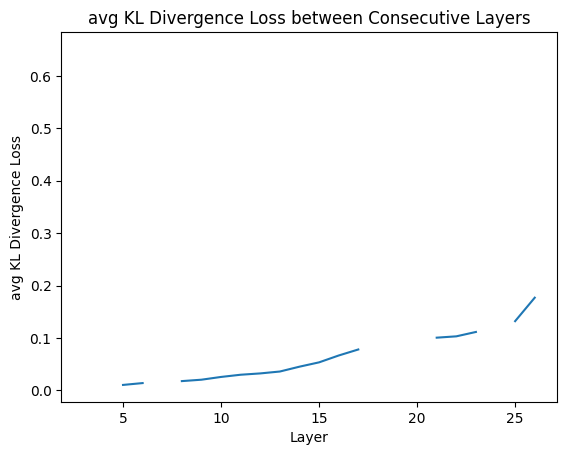

In [35]:
import matplotlib.pyplot as plt
# Cross-Entropy Loss
plt.plot(mean_cross_entropy)
plt.xlabel('Layer')
plt.ylabel('avg Cross-Entropy Loss')
plt.title('avg Cross-Entropy Loss between Consecutive Layers')
plt.show()

# KL Divergence Loss
plt.plot(mean_kl_div)
plt.xlabel('Layer')
plt.ylabel('avg KL Divergence Loss')
plt.title('avg KL Divergence Loss between Consecutive Layers')
plt.show()

## Analyzing Wall Times

We will now break down and analyze the wall times during the inference process.

You might notice a significant time consumption during the initialization phase. This is primarily due to the GPU cache initialization process on the first run.

For a clearer perspective, you can try rerunning the decoding segment again to observe the differences.

In [43]:
max_length = 50

def format_string(text, value, max_length):
    value_str = "{:.3f}".format(value)
    return f"{text:<{max_length - len(value_str)}}{value_str}"

time_init = np.sum(wall_time['init'] )
time_medusa = np.sum(wall_time['medusa'] )
time_tree = np.sum(wall_time['tree'] )
time_posterior = np.sum(wall_time['posterior'] )
time_update = np.sum(wall_time['update'] )
time_total = time_init + time_medusa + time_tree + time_posterior + time_update

print('='*max_length)
print(format_string("Wall time init: ", time_init, max_length))
print(format_string("Wall time medusa: ", time_medusa, max_length))
print(format_string("Wall time Tree: ", time_tree, max_length))
print(format_string("Wall time Posterior: ", time_posterior, max_length))
print(format_string("Wall time Update: ", time_update, max_length))
print('-'*max_length)
print(format_string("Wall time portion medusa: ", time_medusa / time_total, max_length))
print(format_string("Wall time portion Tree: ", time_tree / time_total, max_length))
print(format_string("Wall time portion Posterior: ", time_posterior / time_total, max_length))
print(format_string("Wall time portion Update: ", time_update / time_total, max_length))
print('-'*max_length)
print(format_string("Tokens/second: ", new_token / time_total, max_length))
print('='*max_length)

Wall time init:                              0.243
Wall time medusa:                            0.059
Wall time Tree:                              6.639
Wall time Posterior:                         0.042
Wall time Update:                            0.040
--------------------------------------------------
Wall time portion medusa:                    0.008
Wall time portion Tree:                      0.945
Wall time portion Posterior:                 0.006
Wall time portion Update:                    0.006
--------------------------------------------------
Tokens/second:                              57.386
